# Libraries

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import datetime as dt
import mplfinance 
from renkodf import Renko
from scipy.signal import lfilter
import fx # personal functions
# import MetaTrader5 as mt5

# Gathering Data

In [22]:
# collect the actual data from csv file
# filename = "C:/Users/WilliamFetzner/Documents/Trading/DAT_XLSX_EURUSD_M1_2023.xlsx"
filename = "C:/Users/WilliamFetzner/Documents/Trading/EURUSD1.csv"
df = pd.read_csv(filename, header=None, names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])
df.head(10)

,date,time,open,high,low,close,volume
0,1971.01.04,00:00,0.5369,0.5369,0.5369,0.5369,1
1,1971.01.05,00:00,0.5366,0.5366,0.5366,0.5366,1
2,1971.01.06,00:00,0.5365,0.5365,0.5365,0.5365,1
3,1971.01.07,00:00,0.5368,0.5368,0.5368,0.5368,1
4,1971.01.08,00:00,0.5371,0.5371,0.5371,0.5371,1
5,1971.01.11,00:00,0.5371,0.5371,0.5371,0.5371,1
6,1971.01.12,00:00,0.5371,0.5371,0.5371,0.5371,1
7,1971.01.13,00:00,0.5373,0.5373,0.5373,0.5373,1
8,1971.01.14,00:00,0.5372,0.5372,0.5372,0.5372,1
9,1971.01.15,00:00,0.5376,0.5376,0.5376,0.5376,1


In [24]:
# convert date to datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y.%m.%d %H:%M')
# filter the data to just 2023
start_date = '2023-01-01 00:00:00'
end_date = '2023-12-31 11:59:00'
mask = (df['datetime'] >= start_date) & (df['datetime'] <= end_date)
df_2023 = df.loc[mask]
df_2023.head(10)

,date,time,open,high,low,close,volume,datetime
8665460,2023.01.02,07:02,1.07016,1.07017,1.07016,1.07017,2,2023-01-02 07:02:00
8665461,2023.01.02,07:05,1.07015,1.07015,1.07015,1.07015,1,2023-01-02 07:05:00
8665462,2023.01.02,07:06,1.07014,1.07014,1.07014,1.07014,1,2023-01-02 07:06:00
8665463,2023.01.02,07:08,1.06986,1.06986,1.06956,1.06956,6,2023-01-02 07:08:00
8665464,2023.01.02,07:10,1.06961,1.06961,1.06961,1.06961,1,2023-01-02 07:10:00
8665465,2023.01.02,07:11,1.06963,1.06963,1.06909,1.06919,8,2023-01-02 07:11:00
8665466,2023.01.02,07:14,1.06972,1.06972,1.06972,1.06972,1,2023-01-02 07:14:00
8665467,2023.01.02,07:15,1.06969,1.06969,1.06969,1.06969,1,2023-01-02 07:15:00
8665468,2023.01.02,07:17,1.06970,1.06970,1.06970,1.06970,1,2023-01-02 07:17:00
8665469,2023.01.02,07:20,1.06976,1.06976,1.06976,1.06976,1,2023-01-02 07:20:00


In [25]:
# df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d%H%M')

# drop the volume column
df_2023 = df_2023.drop(columns=['volume'])

# Getting Data Ready

In [26]:
df_2023.columns

Index(['date', 'time', 'open', 'high', 'low', 'close', 'datetime'], dtype='object')

In [27]:
ohlc = df_2023.loc[:, ['datetime', 'open', 'high', 'low', 'close']]
# convert datetime to index
ohlc = ohlc.set_index('datetime')

# filter ohlc to just be between December 1st and December 31st
ohlc_dec = ohlc.loc['2023-12-01':'2023-12-31']
# filter to just the first day
ohlc_dec_1 = ohlc_dec.loc['2023-12-04']
# combine the times into a 15 min interval
ohlc_dec_1_day_15_min = ohlc_dec_1.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})

ohlc_dec_1_day_15_min

,open,high,low,close
datetime,,,,
2023-12-04 00:00:00,1.08738,1.08811,1.08738,1.08807
2023-12-04 00:15:00,1.08807,1.08871,1.08807,1.08850
2023-12-04 00:30:00,1.08851,1.08886,1.08844,1.08863
2023-12-04 00:45:00,1.08862,1.08889,1.08828,1.08862
2023-12-04 01:00:00,1.08862,1.08878,1.08784,1.08839
...,...,...,...,...
2023-12-04 22:45:00,1.08335,1.08355,1.08322,1.08340
2023-12-04 23:00:00,1.08341,1.08364,1.08328,1.08347
2023-12-04 23:15:00,1.08348,1.08366,1.08341,1.08358


# Exploratory Data Analysis
To make sure that the PSAR and Impulse are correctly duplicated from Pinescript to python

In [28]:
# ohlc.open.count()
# 1819/322638 old data
# 0.5% of the time it skips minutes
# and 100 of those it was skipping 2 hrs

# 89/371342
# 0.02% of the time it skips minutes
# and the largest range of skips is 3-28 minutes 
# for an avg of 7 minutes


In [29]:

# # find the difference in minutes between each row
# ohlc['diff'] = ohlc.index.to_series().diff().dt.total_seconds().div(60, fill_value=0)
# # find the difference in days between each row, place a 0 if it is the same day
# ohlc['diff_day'] = ohlc.index.to_series().diff().dt.days.fillna(0)
# # filter to where the diff is > 1 but the diff_day is 0
# ohlc_fil = ohlc.loc[(ohlc['diff'] > 1) & (ohlc['diff_day'] == 0)]
# # sort ohlc_fil by the diff column
# ohlc_fil = ohlc_fil.sort_values(by=['diff'], ascending=False)
# ohlc_fil.head(90)
# # find the avg of diff
# ohlc_fil['diff'].mean()


In [30]:
# filter ohlc to be between march 23rd 12:00 and march 23rd 19:00
# ohlc_march_23 = ohlc.loc['2023-03-23 14:00':'2023-03-23 18:00']
# ohlc_march_23

# Calculations

## PSAR Calculation

In [31]:
# Define inputs
start = 0.02
increment = 0.02
maximum = 0.2
width = 2
highlightStartPoints = True
showLabels = True
highlightState = True


# Calculate PSAR
high = np.array(ohlc_dec_1_day_15_min['high']) # replace with actual high prices
low = np.array(ohlc_dec_1_day_15_min['low']) # replace with actual low prices
close = np.array(ohlc_dec_1_day_15_min['close']) # replace with actual closing prices
psar_obj = fx.PSAR(start, increment, maximum)
psar = np.empty_like(high)
for i in range(len(high)):
   psar[i] = psar_obj.calcPSAR(high[i], low[i])


# Determine direction
dir = np.where(psar < close, 1, -1)

# Create DataFrame
df_psar = pd.DataFrame({
   'Close': close,
   'PSAR': psar,
   'Direction': dir
})

# add a new column to the dataframe that is 'red' if the psar is above the close and 'green' if the psar is below the close
df_psar['Color'] = np.where(df_psar['PSAR'] > df_psar['Close'], 'red', 'green')




In [32]:
df_psar

,Close,PSAR,Direction,Color
0,1.08807,NaN,-1,green
1,1.08850,NaN,-1,green
2,1.08863,1.087380,1,green
3,1.08862,1.087439,1,green
4,1.08839,1.087526,1,green
...,...,...,...,...
91,1.08340,1.081385,1,green
92,1.08347,1.081688,1,green
93,1.08358,1.082001,1,green
94,1.08346,1.082299,1,green


## Impulse MACD Calculation

In [33]:
# Calculate Impulse MACD
df_impulse = fx.calc_impulse_macd(ohlc_dec_1_day_15_min)
df_impulse

,open,high,low,close,hlc3,hi,lo,mi,md,sb,sh,mdc
datetime,,,,,,,,,,,,
2023-12-04 00:00:00,1.08738,1.08811,1.08738,1.08807,1.087853,1.088110,1.087380,1.087853,0.000000,NaN,NaN,green
2023-12-04 00:15:00,1.08807,1.08871,1.08807,1.08850,1.088427,1.088128,1.087400,1.088292,0.000164,NaN,NaN,lime
2023-12-04 00:30:00,1.08851,1.08886,1.08844,1.08863,1.088643,1.088149,1.087431,1.088529,0.000380,NaN,NaN,lime
2023-12-04 00:45:00,1.08862,1.08889,1.08828,1.08862,1.088597,1.088171,1.087456,1.088602,0.000431,NaN,NaN,lime
2023-12-04 01:00:00,1.08862,1.08878,1.08784,1.08839,1.088337,1.088189,1.087467,1.088532,0.000343,NaN,NaN,orange
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04 22:45:00,1.08335,1.08355,1.08322,1.08340,1.083390,1.084845,1.084138,1.081980,-0.002159,-0.002540,0.000381,green
2023-12-04 23:00:00,1.08341,1.08364,1.08328,1.08347,1.083463,1.084810,1.084113,1.082073,-0.002040,-0.002459,0.000419,green
2023-12-04 23:15:00,1.08348,1.08366,1.08341,1.08358,1.083550,1.084776,1.084092,1.082170,-0.001922,-0.002365,0.000442,green


In [34]:
# remove all rows with null values for sh
df_impulse_no_sh_na = df_impulse.dropna(subset=['sh'])
# find the max and min of sh
sh_max = df_impulse_no_sh_na['sh'].max()
sh_min = df_impulse_no_sh_na['sh'].min()


In [35]:
# remove all rows with null values for sb
df_impulse_no_sb_na = df_impulse.dropna(subset=['sb'])
# find the max and min of sb
sb_max = df_impulse_no_sb_na['sb'].max()
sb_min = df_impulse_no_sb_na['sb'].min()

In [36]:
y_min = min(sh_min, sb_min)
y_max = max(sh_max, sb_max)

In [37]:
# find crossover points of sh and sb by seeing when the sign of 'md' goes from being > 0 to < 0, or vice versa but don't include 0
df_impulse['md_sign'] = np.sign(df_impulse['md'])

# crossover would be when 'md_sign' == 1 or -1 and the previous value of 'md_sign' was 0 or -1 or 1 respectively
df_impulse['crossover'] = np.where((df_impulse['md_sign'] == 1) & ((df_impulse['md_sign'].shift(1) == 0) | (df_impulse['md_sign'].shift(1) == -1)), 1, 
                                np.where((df_impulse['md_sign'] == -1) & ((df_impulse['md_sign'].shift(1) == 0) | (df_impulse['md_sign'].shift(1) == 1)), -1, 0))

# filter to just where crossover is not 0
df_impulse_crossover = df_impulse.loc[df_impulse['crossover'] != 0]
df_impulse_crossover

,open,high,low,close,hlc3,hi,lo,mi,md,sb,sh,mdc,md_sign,crossover
datetime,,,,,,,,,,,,,,
2023-12-04 00:15:00,1.08807,1.08871,1.08807,1.0885,1.088427,1.088128,1.087400,1.088292,0.000164,NaN,NaN,lime,1.0,1
2023-12-04 07:15:00,1.08701,1.08712,1.08684,1.0870,1.086987,1.088108,1.087498,1.087486,-0.000012,-0.000001,-0.000011,red,-1.0,-1


In [38]:
# filter to between 1 am and 2 am
df_impulse_signal_1_to_2 = df_impulse.between_time('8:30', '9:30')
df_impulse_signal_1_to_2

,open,high,low,close,hlc3,hi,lo,mi,md,sb,sh,mdc,md_sign,crossover
datetime,,,,,,,,,,,,,,
2023-12-04 08:30:00,1.08764,1.08765,1.08718,1.08734,1.087390,1.088018,1.087433,1.087306,-0.000128,-0.000065,-0.000063,green,-1.0,0
2023-12-04 08:45:00,1.08734,1.08735,1.08671,1.08690,1.086987,1.087999,1.087412,1.087247,-0.000165,-0.000083,-0.000082,red,-1.0,0
2023-12-04 09:00:00,1.08687,1.08691,1.08636,1.08648,1.086583,1.087967,1.087381,1.087144,-0.000237,-0.000110,-0.000127,red,-1.0,0
2023-12-04 09:15:00,1.08648,1.08684,1.08629,1.08651,1.086547,1.087933,1.087349,1.087048,-0.000301,-0.000143,-0.000158,red,-1.0,0
2023-12-04 09:30:00,1.08651,1.08652,1.08536,1.08546,1.085780,1.087892,1.087291,1.086868,-0.000422,-0.000189,-0.000234,red,-1.0,0


In [39]:
def find_min_max(df, col):
    df_no_na = df.dropna(subset=[col])
    min = df_no_na[col].min()
    max = df_no_na[col].max()
    return min, max

In [40]:
import matplotlib.pyplot as plt

# Assuming 'df_impulse' is your DataFrame and it has been processed by 'calc_impulse_macd' function
def impulse_graph(df_impulse, col1, col2):
    sh_min, sh_max = find_min_max(df_impulse, col1)
    sb_min, sb_max = find_min_max(df_impulse, col2)
    
    y_min = min(sh_min, sb_min)
    y_max = max(sh_max, sb_max)
    # Create a new figure
    fig, ax = plt.subplots()

    # Plot the Impulse Histogram
    ax.plot(df_impulse[col1], label='ImpulseSignal', color='blue')

    # Plot the Impulse MACD CD Signal
    ax.plot(df_impulse[col2], label='ImpulseMACDSignal', color='orange')

    # change the x axis to be much smaller and go from the max of sh and sb to the min of sh and sb
    ax.set_ylim([y_min - 0.000001, y_max + 0.000001])

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()


## Plotting

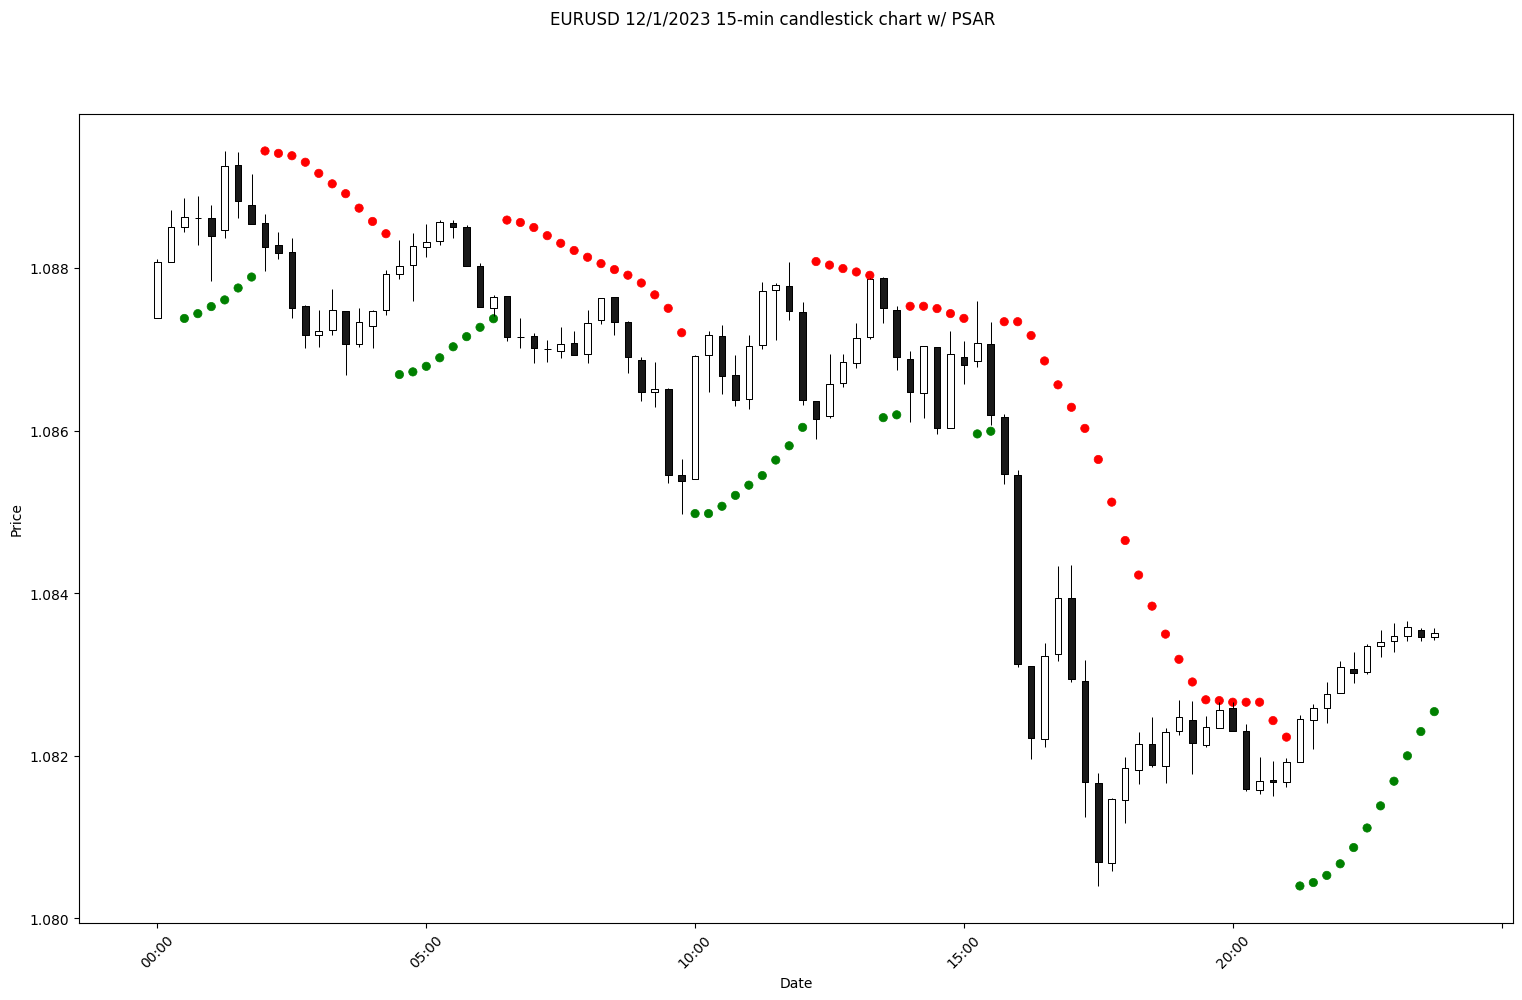

In [41]:
# Plot
fig, ax = plt.subplots()
mplfinance.plot(ohlc_dec_1_day_15_min, type='candle', ax=ax, volume=False, show_nontrading=False)
# add the psar scatterplot to the chart
plt.scatter(df_psar.index, df_psar['PSAR'], color=df_psar['Color'], lw=0.5, label='PSAR')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('EURUSD 12/1/2023 15-min candlestick chart w/ PSAR')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()

## Renko Charts

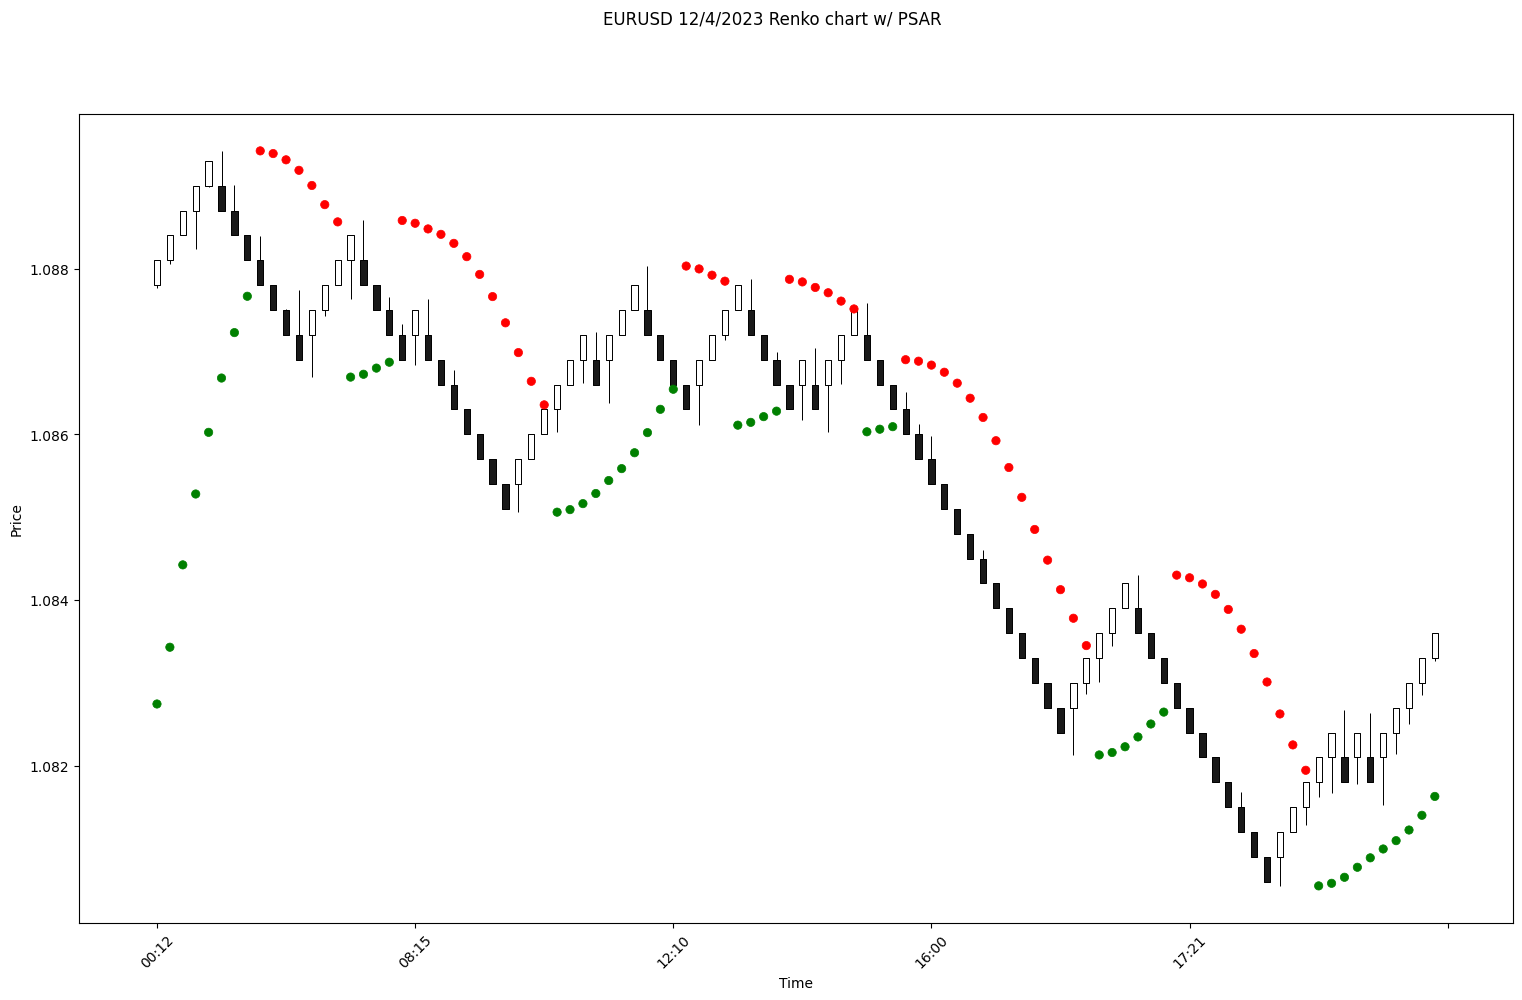

In [42]:
# create a renko chart from the ohlc_dec_1 dataframe
r = Renko(ohlc_dec_1, brick_size=0.0003)
# create a new dataframe from the renko features
renko_df_ready = r.renko_df()
renko_high = np.array(renko_df_ready['high'])
renko_low = np.array(renko_df_ready['low'])
renko_close = np.array(renko_df_ready['close'])
# recalculate psar for the renko chart
psar_renko = np.empty_like(renko_high)
for i in range(len(renko_high)):
   psar_renko[i] = psar_obj.calcPSAR(renko_high[i], renko_low[i])
# Create DataFrame
df_psar_renko = pd.DataFrame({
   'Close': renko_close,
   'PSAR': psar_renko,
})
# add a new column to the dataframe that is 'red' if the psar is above the close and 'green' if the psar is below the close
df_psar_renko['Color'] = np.where(df_psar_renko['PSAR'] > df_psar_renko['Close'], 'red', 'green')

# plot the renko chart
fig, ax = plt.subplots()
mplfinance.plot(renko_df_ready, type='candle', ax=ax, volume=False, show_nontrading=False)
# add the psar scatterplot to the chart
plt.scatter(df_psar_renko.index, df_psar_renko['PSAR'], color=df_psar_renko['Color'], lw=0.5, label='PSAR')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
fig.suptitle('EURUSD 12/4/2023 Renko chart w/ PSAR')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()



# Testing Data

## Parameters

In [43]:
# Renko variable
brick_size = 0.000325

# psar variables
start = 0.02
increment = 0.02
maximum = 0.2

# impulse variables
lengthMA = 34
lengthSignal = 9

# Lot Size
lot_size = 10
per_lot = 100000

# stop loss
stop_loss = 0.000325*2

# Commissions
nova_commission = lot_size * -3
msolutions_commission = lot_size * -5

# starting balance
balance = 200000

# base currency rate
base_currency_rate = 0.045 # EUR
quote_currency_rate = 0.055 # USD

## Renko charts (from 1 min data)

In [44]:
# create a renko chart from the ohlc_dec_1 dataframe
r_full = Renko(ohlc, brick_size=brick_size)
# create a new dataframe from the renko features
renko_full_data = r_full.renko_df()
renko_high_full = np.array(renko_full_data['high'])
renko_low_full = np.array(renko_full_data['low'])
renko_close_full = np.array(renko_full_data['close'])
# generate a blank array for the psar_renko_full
psar_renko_full = np.empty_like(renko_high_full)
# recalculate psar for the renko chart
for i in range(len(renko_high_full)):
   psar_renko_full[i] = psar_obj.calcPSAR(renko_high_full[i], renko_low_full[i])

# append the psar_renko_full to the renko_full_data dataframe
renko_full_data['psar'] = psar_renko_full

# add a new column to the dataframe that is 'short' if the psar is above the close and 'buy' if the psar is below the close - This is the entry signal from PSAR
renko_full_data['psar_signal'] = np.where(renko_full_data['psar'] > renko_full_data['close'], 'short', 'buy')
renko_full_data['psar_color'] = np.where(renko_full_data['psar'] > renko_full_data['close'], 'red', 'green')

# rename 'volume' to 'nbars'
renko_full_data = renko_full_data.rename(columns={'volume': 'nbars'})

renko_full_data.tail(10)

,open,high,low,close,nbars,psar,psar_signal,psar_color
datetime,,,,,,,,
2023-12-29 21:05:00,1.105325,1.105970,1.105000,1.105000,24.0,1.104733,buy,green
2023-12-29 21:09:00,1.105000,1.105000,1.104675,1.104675,5.0,1.106620,short,red
2023-12-29 21:22:00,1.104675,1.104690,1.104350,1.104350,14.0,1.106581,short,red
2023-12-29 21:33:00,1.104350,1.104410,1.104025,1.104025,12.0,1.106492,short,red
2023-12-29 22:08:00,1.104350,1.104675,1.103840,1.104675,36.0,1.106344,short,red
2023-12-29 22:16:00,1.104675,1.105000,1.104675,1.105000,9.0,1.106144,short,red
2023-12-29 22:44:00,1.104675,1.105060,1.104350,1.104350,29.0,1.105959,short,red
2023-12-29 22:54:00,1.104350,1.104350,1.104025,1.104025,11.0,1.105790,short,red
2023-12-29 23:08:00,1.104025,1.104110,1.103700,1.103700,15.0,1.105634,short,red


In [45]:
# Add the Impulse MACD CD Signal to the renko_full_data dataframe
renko_full_data = fx.calc_impulse_macd(renko_full_data)

# find crossover points of sh and sb by seeing when the sign of 'md' goes from being > 0 to < 0, or vice versa but don't include 0
renko_full_data['sh_sign'] = np.sign(renko_full_data['sh'])

# crossover would be when 'sh_sign' == 1 or -1 and the previous value of 'sh_sign' was 0 or -1 or 1 respectively
renko_full_data['crossover'] = np.where((renko_full_data['sh_sign'] == 1) & ((renko_full_data['sh_sign'].shift(1) == 0) | (renko_full_data['sh_sign'].shift(1) == -1)), 1, 
                                np.where((renko_full_data['sh_sign'] == -1) & ((renko_full_data['sh_sign'].shift(1) == 0) | (renko_full_data['sh_sign'].shift(1) == 1)), -1, 0))

# indicate the trade signal for Impulse
renko_full_data['impulse_signal'] = np.where(renko_full_data['sh_sign'] == 1, 'buy', np.where(renko_full_data['sh_sign'] == -1, 'short', 'none'))
renko_full_data.tail(10)

,open,high,low,close,nbars,psar,psar_signal,psar_color,hlc3,hi,lo,mi,md,sb,sh,mdc,sh_sign,crossover,impulse_signal
datetime,,,,,,,,,,,,,,,,,,,
2023-12-29 21:05:00,1.105325,1.105970,1.105000,1.105000,24.0,1.104733,buy,green,1.105323,1.106752,1.106178,1.105529,-0.000649,-0.000610,-0.000039,red,-1.0,0,short
2023-12-29 21:09:00,1.105000,1.105000,1.104675,1.104675,5.0,1.106620,short,red,1.104783,1.106700,1.106134,1.105421,-0.000712,-0.000622,-0.000090,red,-1.0,0,short
2023-12-29 21:22:00,1.104675,1.104690,1.104350,1.104350,14.0,1.106581,short,red,1.104463,1.106641,1.106081,1.105288,-0.000793,-0.000641,-0.000152,red,-1.0,0,short
2023-12-29 21:33:00,1.104350,1.104410,1.104025,1.104025,12.0,1.106492,short,red,1.104153,1.106576,1.106021,1.105133,-0.000888,-0.000671,-0.000217,red,-1.0,0,short
2023-12-29 22:08:00,1.104350,1.104675,1.103840,1.104675,36.0,1.106344,short,red,1.104397,1.106520,1.105957,1.105019,-0.000938,-0.000710,-0.000228,red,-1.0,0,short
2023-12-29 22:16:00,1.104675,1.105000,1.104675,1.105000,9.0,1.106144,short,red,1.104892,1.106475,1.105919,1.104970,-0.000949,-0.000753,-0.000196,green,-1.0,0,short
2023-12-29 22:44:00,1.104675,1.105060,1.104350,1.104350,29.0,1.105959,short,red,1.104587,1.106433,1.105873,1.104893,-0.000980,-0.000796,-0.000184,red,-1.0,0,short
2023-12-29 22:54:00,1.104350,1.104350,1.104025,1.104025,11.0,1.105790,short,red,1.104133,1.106372,1.105818,1.104772,-0.001046,-0.000843,-0.000203,red,-1.0,0,short
2023-12-29 23:08:00,1.104025,1.104110,1.103700,1.103700,15.0,1.105634,short,red,1.103837,1.106306,1.105756,1.104631,-0.001126,-0.000898,-0.000228,red,-1.0,0,short


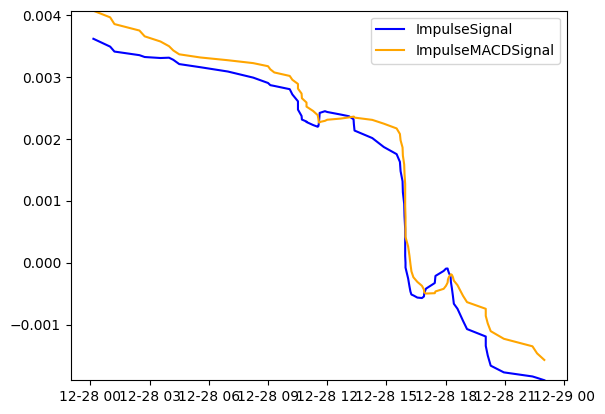

In [46]:
# filter to just 12-28-23
renko_full_data_12_28 = renko_full_data.loc['2023-12-28']
impulse_graph(renko_full_data_12_28, 'md', 'sb')

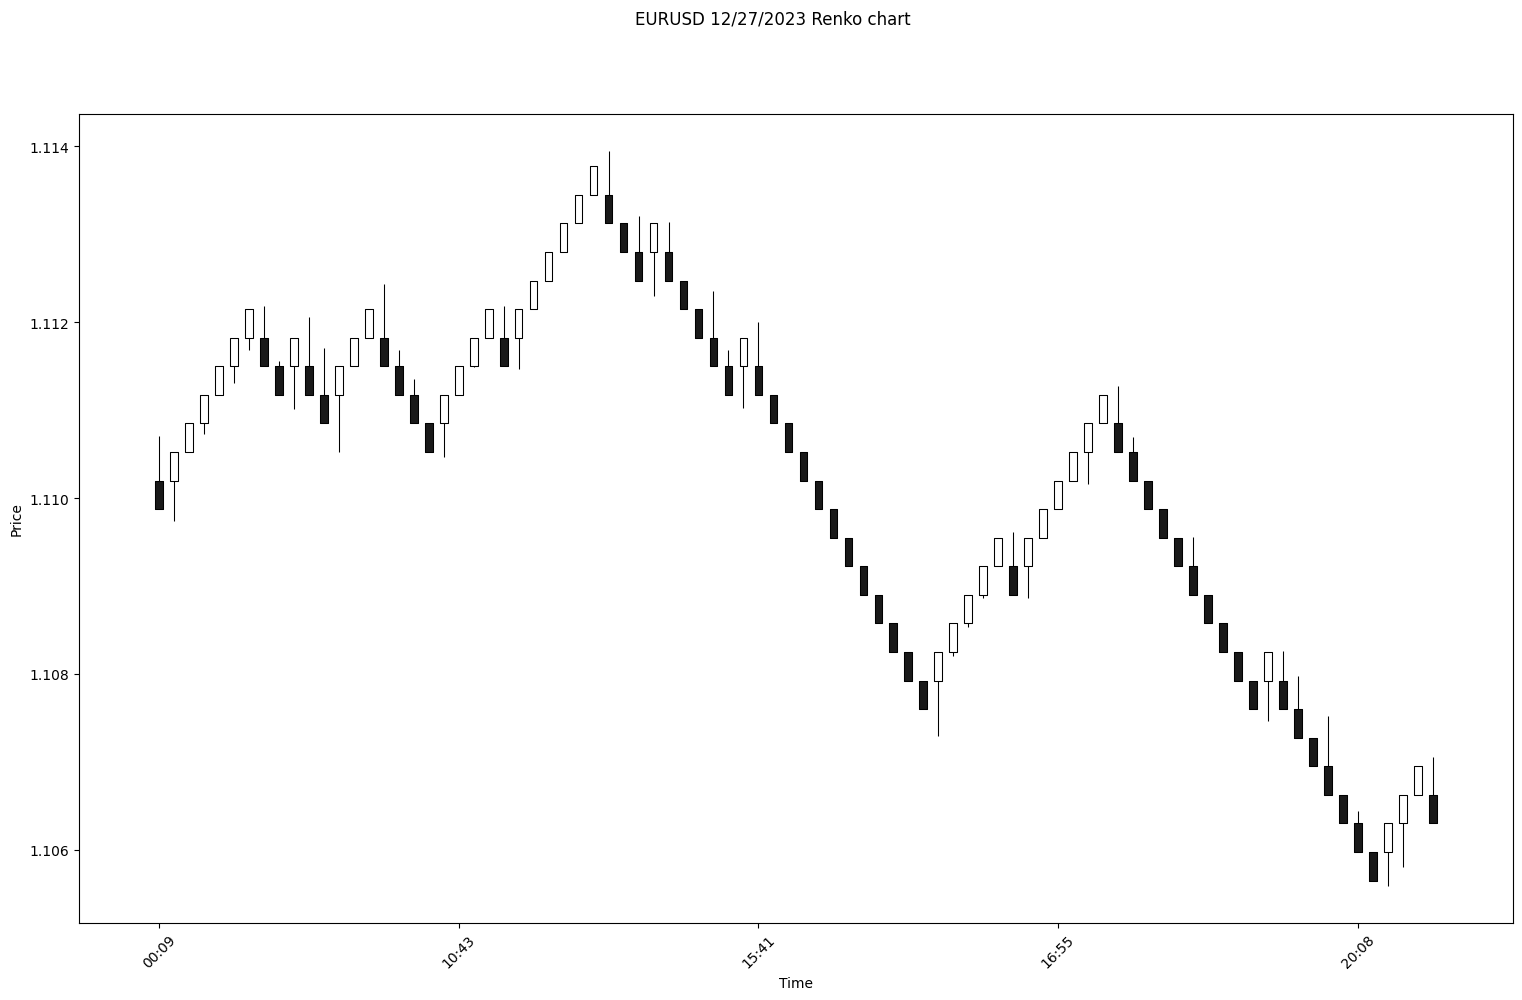

In [47]:
# plot the renko chart
fig, ax = plt.subplots()
mplfinance.plot(renko_full_data_12_28, type='candle', ax=ax, volume=False, show_nontrading=False)
# add the psar scatterplot to the chart
# plt.scatter(df_psar_renko.index, df_psar_renko['PSAR'], color=df_psar_renko['Color'], lw=0.5, label='PSAR')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
fig.suptitle('EURUSD 12/27/2023 Renko chart')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()

In [48]:
# add a column to renko_full_data that will indicate the color of the renko brick based on the "open" and "close" columns of the renko_full_data dataframe, 
# if the open is greater than the close then the color is red, otherwise it is green
renko_full_data['brick_color'] = np.where(renko_full_data['open'] > renko_full_data['close'], 'red', 'green')

In [49]:
# add the day of the week to the dataframe
renko_full_data['day_of_week'] = renko_full_data.index.day_name()
# place a 1 in day_of_week_transition, if it is the last bar on Friday and the next bar is Sunday
renko_full_data['day_of_week_transition'] = np.where((renko_full_data['day_of_week'] == 'Friday') & (renko_full_data['day_of_week'].shift(-1) == 'Sunday'), 1, 0)

## Entry conditions

In [50]:
# add a column that will be the entry signal for the strategy to be when both impulse_signal and psar_signal are both 'buy' or 'short'
renko_full_data['entry_signal'] = np.where((renko_full_data['psar_signal'] == 'buy') & (renko_full_data['impulse_signal'] == 'buy') 
                                           & (renko_full_data['brick_color'] == 'green') & (renko_full_data['day_of_week_transition'] != 1), 'buy', 
                                        np.where((renko_full_data['psar_signal'] == 'short') & (renko_full_data['impulse_signal'] == 'short') & 
                                                 (renko_full_data['brick_color'] == 'red') & (renko_full_data['day_of_week_transition'] != 1), 'short', 'none'))

# if there was a change from 'none' to 'buy' or 'short' then that is an entry signal and replace the 'buy' or 'short' with 'entry + buy' or 'entry + short'
renko_full_data['entry_signal'] = np.where((renko_full_data['entry_signal'] != 'none') & (renko_full_data['entry_signal'].shift(1) == 'none'),
                                            'entry + ' + renko_full_data['entry_signal'], renko_full_data['entry_signal'])


# add a stop loss column that will be the entry price +/- the brick size for when the entry signal is 'entry + buy' or 'entry + short'
renko_full_data['stop_loss'] = np.where(renko_full_data['entry_signal'] == 'entry + buy', renko_full_data['open'] - stop_loss,
                                        np.where(renko_full_data['entry_signal'] == 'entry + short', renko_full_data['open'] + stop_loss, np.nan))

In [51]:
# if the 'entry_signal' colummn goes from 'entry + short' or 'short' to 'none' then 'none' should be replaced with 'exit' in the entry_signal column
renko_full_data['entry_signal'] = np.where((renko_full_data['entry_signal'].shift(1) == 'entry + short') & (renko_full_data['entry_signal'] == 'none'), 'exit', 
                                            np.where((renko_full_data['entry_signal'].shift(1) == 'short') & (renko_full_data['entry_signal'] == 'none'), 'exit', 
                                                     np.where((renko_full_data['entry_signal'].shift(1) == 'entry + buy') & (renko_full_data['entry_signal'] == 'none'), 'exit', 
                                                              np.where((renko_full_data['entry_signal'].shift(1) == 'buy') & (renko_full_data['entry_signal'] == 'none'), 'exit', 
                                                                       renko_full_data['entry_signal']))))

In [52]:
# create a first_TP column that will be the entry price + brick_size if the entry_signal is 'entry + buy' or 'entry + short'
renko_full_data['first_TP_goal'] = np.where(renko_full_data['entry_signal'] == 'entry + buy', renko_full_data['close'] + brick_size,
                                    np.where(renko_full_data['entry_signal'] == 'entry + short', renko_full_data['close'] - brick_size, np.nan))

In [53]:
# position_count will be a cumulative count used to filter the data to the timeframe between the entry 
# and exit signals so anytime there is an "entry + buy" or "entry + short" the count should increase by 1
renko_full_data['position_count'] = np.where(renko_full_data['entry_signal'] == 'entry + buy', 1, np.where(renko_full_data['entry_signal'] == 'entry + short', 1, 0))
renko_full_data['cum_position_count'] = renko_full_data['position_count'].cumsum()
# when 'entry_signal' is 'none' then the 'cum_position_count' should be null
renko_full_data['cum_position_count'] = np.where(renko_full_data['entry_signal'] == 'none', np.nan, renko_full_data['cum_position_count'])

In [54]:
# group by cum_position_count and forward fill the value in the first index of the 'stop_loss' column
renko_full_data['stop_loss'] = renko_full_data.groupby('cum_position_count')['stop_loss'].ffill()
renko_full_data['first_TP_goal'] = renko_full_data.groupby('cum_position_count')['first_TP_goal'].ffill()

In [55]:
# determine whether the exit should be sooner because the stop_loss was hit before the exit signal (look at the high/low of the brick)
renko_full_data['exit_stop_loss'] = np.where((renko_full_data['entry_signal'] == 'buy') & (renko_full_data['stop_loss'] > renko_full_data['low']), 1,
                                        np.where((renko_full_data['entry_signal'] == 'short') & (renko_full_data['stop_loss'] < renko_full_data['high']), 1, 0))


In [56]:
# group by cum_position_count and evaluate whether the first_TP_goal was hit by looking at the high/low of the brick
renko_full_data['first_TP_hit'] = np.where((renko_full_data['entry_signal'] == 'buy') & (renko_full_data['first_TP_goal'] <= renko_full_data['high']), 1,
                                        np.where((renko_full_data['entry_signal'] == 'short') & (renko_full_data['first_TP_goal'] >= renko_full_data['low']), 1,
                                                np.where((renko_full_data['entry_signal'] == 'entry + buy'), 0,
                                                         np.where((renko_full_data['entry_signal'] == 'entry + short'), 0,  np.nan))))
renko_full_data['first_TP_hit'] = renko_full_data.groupby('cum_position_count')['first_TP_hit'].ffill()

In [57]:
# maybe implement this later - right now, let's keep the SL where it is

# # if first_TP_hit is 1 then the stop_loss should be set to the entry close price for that position so we need to group by the cum_position_count
# renko_full_data['stop_loss'] = np.where(renko_full_data['first_TP_hit'] == 1, renko_full_data.groupby('cum_position_count')['close'].transform('first'), renko_full_data['stop_loss'])
# # drop 'stop_loss_test'
# renko_full_data.drop(columns=['stop_loss_test'], inplace=True)
# redetermine whether the new stop_loss was hit after we took the first TP
# renko_full_data['exit_stop_loss'] = np.where((renko_full_data['entry_signal'] == 'buy') & (renko_full_data['stop_loss'] > renko_full_data['low']), 1,
#                                         np.where((renko_full_data['entry_signal'] == 'short') & (renko_full_data['stop_loss'] < renko_full_data['high']), 1, 0))
# renko_full_data.loc[renko_full_data['exit_stop_loss'] == 1]
# happens 908/2371 = 40% of the time

In [58]:
renko_full_data.loc[:,['high','open', 'close', 'low', 'entry_signal', 'stop_loss', 'cum_position_count', 'first_TP_hit', 'first_TP_goal']].tail(25)

,high,open,close,low,entry_signal,stop_loss,cum_position_count,first_TP_hit,first_TP_goal
datetime,,,,,,,,,
2023-12-29 17:49:00,1.106950,1.106950,1.106625,1.106625,none,NaN,NaN,NaN,NaN
2023-12-29 17:49:00,1.106625,1.106625,1.106300,1.106300,none,NaN,NaN,NaN,NaN
2023-12-29 17:49:00,1.106300,1.106300,1.105975,1.105975,none,NaN,NaN,NaN,NaN
2023-12-29 17:49:00,1.105975,1.105975,1.105650,1.105650,none,NaN,NaN,NaN,NaN
2023-12-29 17:53:00,1.106290,1.105650,1.105325,1.105325,entry + short,1.106300,2720.0,0.0,1.105000
2023-12-29 17:57:00,1.105600,1.105325,1.105000,1.105000,short,1.106300,2720.0,1.0,1.105000
2023-12-29 17:57:00,1.105000,1.105000,1.104675,1.104675,short,1.106300,2720.0,1.0,1.105000
2023-12-29 18:09:00,1.105325,1.105000,1.105325,1.104360,exit,1.106300,2720.0,1.0,1.105000
2023-12-29 18:11:00,1.105650,1.105325,1.105650,1.105325,none,NaN,NaN,NaN,NaN


In [59]:
# filter to where cum_position_count is 277
renko_full_data.loc[renko_full_data['cum_position_count'] == 277, ['high','open', 'close', 'low', 'entry_signal', 'stop_loss', 'first_TP_hit', 'first_TP_goal']]

,high,open,close,low,entry_signal,stop_loss,first_TP_hit,first_TP_goal
datetime,,,,,,,,
2023-01-25 11:09:00,1.087890,1.08745,1.087125,1.087125,entry + short,1.0881,0.0,1.0868
2023-01-25 11:19:00,1.087775,1.08745,1.087775,1.087120,exit,1.0881,0.0,1.0868


## Find the P/L

In [60]:
profit_df = pd.DataFrame() #columns=['cum_position_count', 'direction', 'entry_price', 'exit_price', 'first_TP_hit', 'profit']
# calculate the profit for each position by first grouping by each position and finding the entry price
profit_df['entry_price'] = renko_full_data.groupby('cum_position_count')['close'].first()
# separate out the datetime column
renko_full_data['datetime'] = renko_full_data.index
profit_df['entry_time'] = renko_full_data.groupby('cum_position_count')['datetime'].first()
profit_df['exit_time'] = renko_full_data.groupby('cum_position_count')['datetime'].last()

# # determine if the first TP was hit
profit_df['first_TP_hit'] = renko_full_data.groupby('cum_position_count')['first_TP_hit'].max()#.reset_index()['first_TP_hit']
# # determine the exit price
profit_df['exit_price'] = renko_full_data.groupby('cum_position_count')['close'].last()

# # what was the direction, buy or short?
profit_df['direction'] = renko_full_data.groupby('cum_position_count')['entry_signal'].first()
profit_df['direction'] = profit_df['direction'].str.split('+').str[1]
# # calculate the profit
profit_df['secondary_profit'] = np.where((profit_df['direction'].str.strip() == 'buy') & (profit_df['first_TP_hit'] == 1), 
                                         (profit_df['exit_price'] - profit_df['entry_price'])*per_lot*(lot_size/2), 
                                         np.where((profit_df['direction'].str.strip() == 'short') & (profit_df['first_TP_hit'] == 1), 
                                                  (profit_df['entry_price'] - profit_df['exit_price'])*per_lot*(lot_size/2),
                                                   np.where((profit_df['direction'].str.strip() == 'buy') & (profit_df['first_TP_hit'] == 0),
                                                            (profit_df['exit_price'] - profit_df['entry_price'])*per_lot*(lot_size),
                                                            np.where((profit_df['direction'].str.strip() == 'short') & (profit_df['first_TP_hit'] == 0),
                                                                     (profit_df['entry_price'] - profit_df['exit_price'])*per_lot*(lot_size), np.nan))))
profit_df['primary_profit'] = np.where(profit_df['first_TP_hit'] == 1, brick_size*per_lot*(lot_size/2), 0)

# what if I didn't take the first TP?
profit_df['profit'] = np.where((profit_df['direction'].str.strip() == 'buy'),
                                            (profit_df['exit_price'] - profit_df['entry_price'])*per_lot*(lot_size), 
                                            np.where((profit_df['direction'].str.strip() == 'short'),
                                                    (profit_df['entry_price'] - profit_df['exit_price'])*per_lot*(lot_size), np.nan))

### Swap Rates

In [61]:
# find the positions where the period in between the entry_time and exit_time include 5:00 pm 
profit_df = fx.add_swap_rates(profit_df, base_currency_rate, quote_currency_rate, lots=lot_size)
profit_df

,entry_price,entry_time,exit_time,first_TP_hit,exit_price,direction,secondary_profit,primary_profit,profit,swap,swap_rate
cum_position_count,,,,,,,,,,,
1.0,1.067625,2023-01-02 09:47:00,2023-01-02 09:58:00,1.0,1.067300,short,1.625000e+02,162.5,3.250000e+02,0,0.000000
2.0,1.067300,2023-01-02 10:03:00,2023-01-02 10:34:00,0.0,1.067950,short,-6.500000e+02,0.0,-6.500000e+02,0,0.000000
3.0,1.068275,2023-01-02 10:34:00,2023-01-02 10:58:00,1.0,1.067950,buy,-1.625000e+02,162.5,-3.250000e+02,0,0.000000
4.0,1.068600,2023-01-02 11:01:00,2023-01-02 11:06:00,1.0,1.068925,buy,1.625000e+02,162.5,3.250000e+02,0,0.000000
5.0,1.067625,2023-01-02 12:42:00,2023-01-02 12:59:00,0.0,1.068275,short,-6.500000e+02,0.0,-6.500000e+02,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2718.0,1.106625,2023-12-29 16:49:00,2023-12-29 17:42:00,1.0,1.106950,buy,1.625000e+02,162.5,3.250000e+02,1,-24.750224
2719.0,1.107275,2023-12-29 17:47:00,2023-12-29 17:49:00,1.0,1.106950,buy,-1.625000e+02,162.5,-3.250000e+02,0,0.000000
2720.0,1.105325,2023-12-29 17:53:00,2023-12-29 18:09:00,1.0,1.105325,short,-1.110223e-10,162.5,-2.220446e-10,0,0.000000


In [62]:
# filter to just the locations where the swap rate is 1
profit_df.loc[profit_df['swap'] == 1]

,entry_price,entry_time,exit_time,first_TP_hit,exit_price,direction,secondary_profit,primary_profit,profit,swap,swap_rate
cum_position_count,,,,,,,,,,,
6.0,1.067950,2023-01-02 15:46:00,2023-01-02 18:14:00,1.0,1.066650,short,6.500000e+02,162.5,1.300000e+03,1,25.685333
39.0,1.062100,2023-01-04 16:54:00,2023-01-04 17:00:00,1.0,1.061775,buy,-1.625000e+02,162.5,-3.250000e+02,1,-25.803264
55.0,1.055275,2023-01-05 16:26:00,2023-01-05 17:08:00,1.0,1.053975,short,6.500000e+02,162.5,1.300000e+03,1,25.994222
120.0,1.076400,2023-01-11 16:45:00,2023-01-11 17:10:00,1.0,1.076400,buy,-1.110223e-10,162.5,-2.220446e-10,1,-25.452676
158.0,1.080950,2023-01-13 16:48:00,2023-01-13 17:08:00,1.0,1.082250,buy,6.500000e+02,162.5,1.300000e+03,1,-25.315094
...,...,...,...,...,...,...,...,...,...,...,...
2659.0,1.092650,2023-12-18 15:34:00,2023-12-18 17:08:00,1.0,1.092325,buy,-1.625000e+02,162.5,-3.250000e+02,1,-25.081601
2664.0,1.097200,2023-12-19 16:45:00,2023-12-19 17:02:00,1.0,1.097525,buy,1.625000e+02,162.5,3.250000e+02,1,-24.962766
2689.0,1.103375,2023-12-22 16:40:00,2023-12-22 17:20:00,1.0,1.103050,buy,-1.625000e+02,162.5,-3.250000e+02,1,-24.837732


In [63]:
# With initial TP
profit_df['nova_profit_inp'] = profit_df['primary_profit'] + profit_df['secondary_profit'] + nova_commission + profit_df['swap_rate']
profit_df['msolutions_profit_inp'] = profit_df['primary_profit'] + profit_df['secondary_profit'] + msolutions_commission + profit_df['swap_rate']
profit_df

,entry_price,entry_time,exit_time,first_TP_hit,exit_price,direction,secondary_profit,primary_profit,profit,swap,swap_rate,nova_profit_inp,msolutions_profit_inp
cum_position_count,,,,,,,,,,,,,
1.0,1.067625,2023-01-02 09:47:00,2023-01-02 09:58:00,1.0,1.067300,short,1.625000e+02,162.5,3.250000e+02,0,0.000000,295.000000,275.000000
2.0,1.067300,2023-01-02 10:03:00,2023-01-02 10:34:00,0.0,1.067950,short,-6.500000e+02,0.0,-6.500000e+02,0,0.000000,-680.000000,-700.000000
3.0,1.068275,2023-01-02 10:34:00,2023-01-02 10:58:00,1.0,1.067950,buy,-1.625000e+02,162.5,-3.250000e+02,0,0.000000,-30.000000,-50.000000
4.0,1.068600,2023-01-02 11:01:00,2023-01-02 11:06:00,1.0,1.068925,buy,1.625000e+02,162.5,3.250000e+02,0,0.000000,295.000000,275.000000
5.0,1.067625,2023-01-02 12:42:00,2023-01-02 12:59:00,0.0,1.068275,short,-6.500000e+02,0.0,-6.500000e+02,0,0.000000,-680.000000,-700.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718.0,1.106625,2023-12-29 16:49:00,2023-12-29 17:42:00,1.0,1.106950,buy,1.625000e+02,162.5,3.250000e+02,1,-24.750224,270.249776,250.249776
2719.0,1.107275,2023-12-29 17:47:00,2023-12-29 17:49:00,1.0,1.106950,buy,-1.625000e+02,162.5,-3.250000e+02,0,0.000000,-30.000000,-50.000000
2720.0,1.105325,2023-12-29 17:53:00,2023-12-29 18:09:00,1.0,1.105325,short,-1.110223e-10,162.5,-2.220446e-10,0,0.000000,132.500000,112.500000


In [64]:
# no initial TP
profit_df['nova_profit'] = profit_df['profit'] + nova_commission + profit_df['swap_rate']
profit_df['msolutions_profit'] = profit_df['profit'] + msolutions_commission + profit_df['swap_rate']

In [65]:
# find the entry day of the week
profit_df['entry_day_of_week'] = profit_df['entry_time'].dt.day_name()
profit_df['exit_day_of_week'] = profit_df['exit_time'].dt.day_name()

# filter to just those entries on Friday
profit_df_friday = profit_df.loc[profit_df['entry_day_of_week'] == 'Friday']
# find where entry and exit day of the week are different
profit_df_friday['entry_exit_day_of_week'] = np.where(profit_df_friday['entry_day_of_week'] != profit_df_friday['exit_day_of_week'], 1, 0)
# find the number of times the entry and exit day of the week are different
weekend_hold = profit_df_friday.loc[profit_df_friday['entry_exit_day_of_week'] == 1]
weekend_hold

C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_11820\2876058505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_df_friday['entry_exit_day_of_week'] = np.where(profit_df_friday['entry_day_of_week'] != profit_df_friday['exit_day_of_week'], 1, 0)


,entry_price,entry_time,exit_time,first_TP_hit,exit_price,direction,secondary_profit,primary_profit,profit,swap,swap_rate,nova_profit_inp,msolutions_profit_inp,nova_profit,msolutions_profit,entry_day_of_week,exit_day_of_week,entry_exit_day_of_week
cum_position_count,,,,,,,,,,,,,,,,,,
82.0,1.063725,2023-01-06 20:33:00,2023-01-09 00:02:00,1.0,1.064050,buy,1.625000e+02,162.5,3.250000e+02,0,0.0,295.0,275.0,295.0,275.0,Friday,Monday,1
240.0,1.085175,2023-01-20 21:11:00,2023-01-23 03:33:00,1.0,1.089075,buy,1.950000e+03,162.5,3.900000e+03,0,0.0,2082.5,2062.5,3870.0,3850.0,Friday,Monday,1
315.0,1.087125,2023-01-27 21:22:00,2023-01-30 00:03:00,0.0,1.086475,buy,-6.500000e+02,0.0,-6.500000e+02,0,0.0,-680.0,-700.0,-680.0,-700.0,Friday,Monday,1
393.0,1.082250,2023-02-03 20:01:00,2023-02-06 00:09:00,1.0,1.078675,short,1.787500e+03,162.5,3.575000e+03,0,0.0,1920.0,1900.0,3545.0,3525.0,Friday,Monday,1
518.0,1.068600,2023-02-17 20:12:00,2023-02-20 00:02:00,1.0,1.068925,buy,1.625000e+02,162.5,3.250000e+02,0,0.0,295.0,275.0,295.0,275.0,Friday,Monday,1
703.0,1.064050,2023-03-10 22:23:00,2023-03-13 00:00:00,1.0,1.064375,short,-1.625000e+02,162.5,-3.250000e+02,0,0.0,-30.0,-50.0,-355.0,-375.0,Friday,Monday,1
801.0,1.066000,2023-03-17 22:25:00,2023-03-20 00:00:00,0.0,1.066650,short,-6.500000e+02,0.0,-6.500000e+02,0,0.0,-680.0,-700.0,-680.0,-700.0,Friday,Monday,1
875.0,1.076400,2023-03-24 21:28:00,2023-03-27 03:03:00,1.0,1.077050,buy,3.250000e+02,162.5,6.500000e+02,0,0.0,457.5,437.5,620.0,600.0,Friday,Monday,1
931.0,1.085500,2023-03-31 22:00:00,2023-04-03 01:37:00,1.0,1.081600,short,1.950000e+03,162.5,3.900000e+03,0,0.0,2082.5,2062.5,3870.0,3850.0,Friday,Monday,1


## Daily Drawdown

In [66]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each day
profit_df_daily = profit_df_new_index.resample('D').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum',
                                                         'nova_profit_inp': 'sum', 'msolutions_profit_inp': 'sum'})
# fill the null values with 0
profit_df_daily.fillna(0, inplace=True)
# find the min of nova_profit and msolutions_profit
nova_min = profit_df_daily['nova_profit'].min()
msolutions_min = profit_df_daily['msolutions_profit'].min()
# find the days when nova_profit equals nova_min
profit_df_daily.loc[profit_df_daily['nova_profit'] == nova_min]
# 2023-01-11	nova: -4572.5	msolutions: -4912.5

,nova_profit,msolutions_profit,nova_profit_inp,msolutions_profit_inp
entry_time,,,,
2023-10-03,-5676.155527,-5976.155527,-3563.655527,-3863.655527


## Summation and Plotting

In [67]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each week
profit_df_weekly = profit_df_new_index.resample('W').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum',
                                                         'nova_profit_inp': 'sum', 'msolutions_profit_inp': 'sum'})
# fill the null values with 0
profit_df_weekly.fillna(0, inplace=True)
# find the min, max, and mean of nova_profit and msolutions_profit
nova_min = profit_df_weekly['nova_profit'].min()
msolutions_min = profit_df_weekly['msolutions_profit'].min()
nova_max = profit_df_weekly['nova_profit'].max()
msolutions_max = profit_df_weekly['msolutions_profit'].max()
nova_mean = profit_df_weekly['nova_profit'].mean()
msolutions_mean = profit_df_weekly['msolutions_profit'].mean()
print('nova_min: ', nova_min, 'msolutions_min: ', msolutions_min, 'nova_max: ', nova_max, 'msolutions_max: ', msolutions_max, 'nova_mean: ', nova_mean, 'msolutions_mean: ', msolutions_mean)
# nova_min:  -3582.50 msolutions_min:  -4562.50 nova_max:  25144.99 msolutions_max:  23924.99 nova_mean:  6074.66 msolutions_mean:  5179.95

nova_min:  -5938.87111940592 msolutions_min:  -6898.87111940592 nova_max:  33109.44702561786 msolutions_max:  31149.447025617857 nova_mean:  8399.317931963567 msolutions_mean:  7352.39485504049


In [68]:
# filter profit_df_weekly to just september 
profit_df_weekly.loc['2023-09']

,nova_profit,msolutions_profit,nova_profit_inp,msolutions_profit_inp
entry_time,,,,
2023-09-03,14199.678650,13299.678650,7862.178650,6962.178650
2023-09-10,2649.477971,2049.477971,2811.977971,2211.977971
2023-09-17,-3475.483453,-4475.483453,-5587.983453,-6587.983453
2023-09-24,223.746116,-676.253884,-1563.753884,-2463.753884


In [69]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each month
profit_df_monthly = profit_df_new_index.resample('M').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum',
                                                         'nova_profit_inp': 'sum', 'msolutions_profit_inp': 'sum'})
# fill the null values with 0
profit_df_monthly.fillna(0, inplace=True)
# find the min, max, and mean of nova_profit
nova_min = profit_df_monthly['nova_profit'].min()
nova_max = profit_df_monthly['nova_profit'].max()
nova_mean = profit_df_monthly['nova_profit'].mean()
print('nova_min: ', nova_min, 'nova_max: ', nova_max, 'nova_mean: ', nova_mean)
# find where the nova_profit is equal to the nova_min
profit_df_monthly.loc[profit_df_monthly['nova_profit'] == nova_min]
# nova_min:  -1325.000000115916 nova_max:  54662.50002552408 nova_mean:  26829.791681260333

nova_min:  6103.503722099914 nova_max:  57797.87035625356 nova_mean:  36397.04437184212


,nova_profit,msolutions_profit,nova_profit_inp,msolutions_profit_inp
entry_time,,,,
2023-09-30,6103.503722,2423.503722,416.003722,-3263.996278


In [70]:
profit_df_monthly

,nova_profit,msolutions_profit,nova_profit_inp,msolutions_profit_inp
entry_time,,,,
2023-01-31,51464.889075,44624.889075,31314.889075,24474.889075
2023-02-28,48630.557829,43550.557829,25230.557829,20150.557829
2023-03-31,57797.870356,51097.870356,33910.370356,27210.370356
2023-04-30,42325.603458,38425.603458,24613.103458,20713.103458
2023-05-31,32906.638176,28526.638176,18606.638176,14226.638176
2023-06-30,51224.425310,47924.425310,27986.925311,24686.925311
2023-07-31,23111.092513,18851.092513,10761.092513,6501.092513
2023-08-31,36240.032686,31600.032686,22590.032687,17950.032687
2023-09-30,6103.503722,2423.503722,416.003722,-3263.996278


In [71]:
# find the end balance for nova profit and msolutions profit by summing the profits and adding to the starting balance
nova_end_balance = balance + profit_df['nova_profit'].sum()
# convert to dollars
nova_end_balance_dollars = '${:,.2f}'.format(nova_end_balance)
msolutions_end_balance = balance + profit_df['msolutions_profit'].sum()
msolutions_end_balance_dollars = '${:,.2f}'.format(msolutions_end_balance)
print(f'Nova End Balance: {nova_end_balance_dollars}')
print(f'MSolutions End Balance: {msolutions_end_balance_dollars}')
# with initial TP
# Nova End Balance: $521,957.50
# MSolutions End Balance: $474,537.50

Nova End Balance: $636,764.53
MSolutions End Balance: $582,324.53


In [72]:
total_take_home = ((nova_end_balance-balance)*.8 )+ ((msolutions_end_balance-balance)*.75)
print(total_take_home)
# with initial TP
# 463469.12

636155.0253162633


In [73]:
100000/(total_take_home/52)

8.174108185995747

In [74]:
# calculate the win rate for nova
nova_win_rate = profit_df.loc[profit_df['nova_profit'] > 0].shape[0] / profit_df.shape[0]
msolutions_win_rate = profit_df.loc[profit_df['msolutions_profit'] > 0].shape[0] / profit_df.shape[0]
nova_win_rate_inp = profit_df.loc[profit_df['nova_profit_inp'] > 0].shape[0] / profit_df.shape[0]
msolutions_win_rate_inp = profit_df.loc[profit_df['msolutions_profit_inp'] > 0].shape[0] / profit_df.shape[0]
# find the number of times that initial TP was hit and then the 
print('Nova Win Rate: ', nova_win_rate, 'MSolutions Win Rate: ', msolutions_win_rate, 'Nova Win Rate with Initial TP: ',
       nova_win_rate_inp, 'MSolutions win rate with Initial TP: ', msolutions_win_rate_inp)


Nova Win Rate:  0.3662747979426892 MSolutions Win Rate:  0.3662747979426892 Nova Win Rate with Initial TP:  0.5183688464364438 MSolutions win rate with Initial TP:  0.5183688464364438


In [75]:
# find the min for nova_profit and msolutions_profit
nova_min = profit_df['nova_profit'].min()
msolutions_min = profit_df['msolutions_profit'].min()
print(f'Nova Min: ${nova_min}')
print(f'MSolutions Min: ${msolutions_min}')



Nova Min: $-705.3226982221647
MSolutions Min: $-725.3226982221647


In [76]:
# create a new column for cum_sum of nova_profit and msolutions_profit
profit_df['nova_cum_sum'] = profit_df['nova_profit'].cumsum()
profit_df['msolutions_cum_sum'] = profit_df['msolutions_profit'].cumsum()

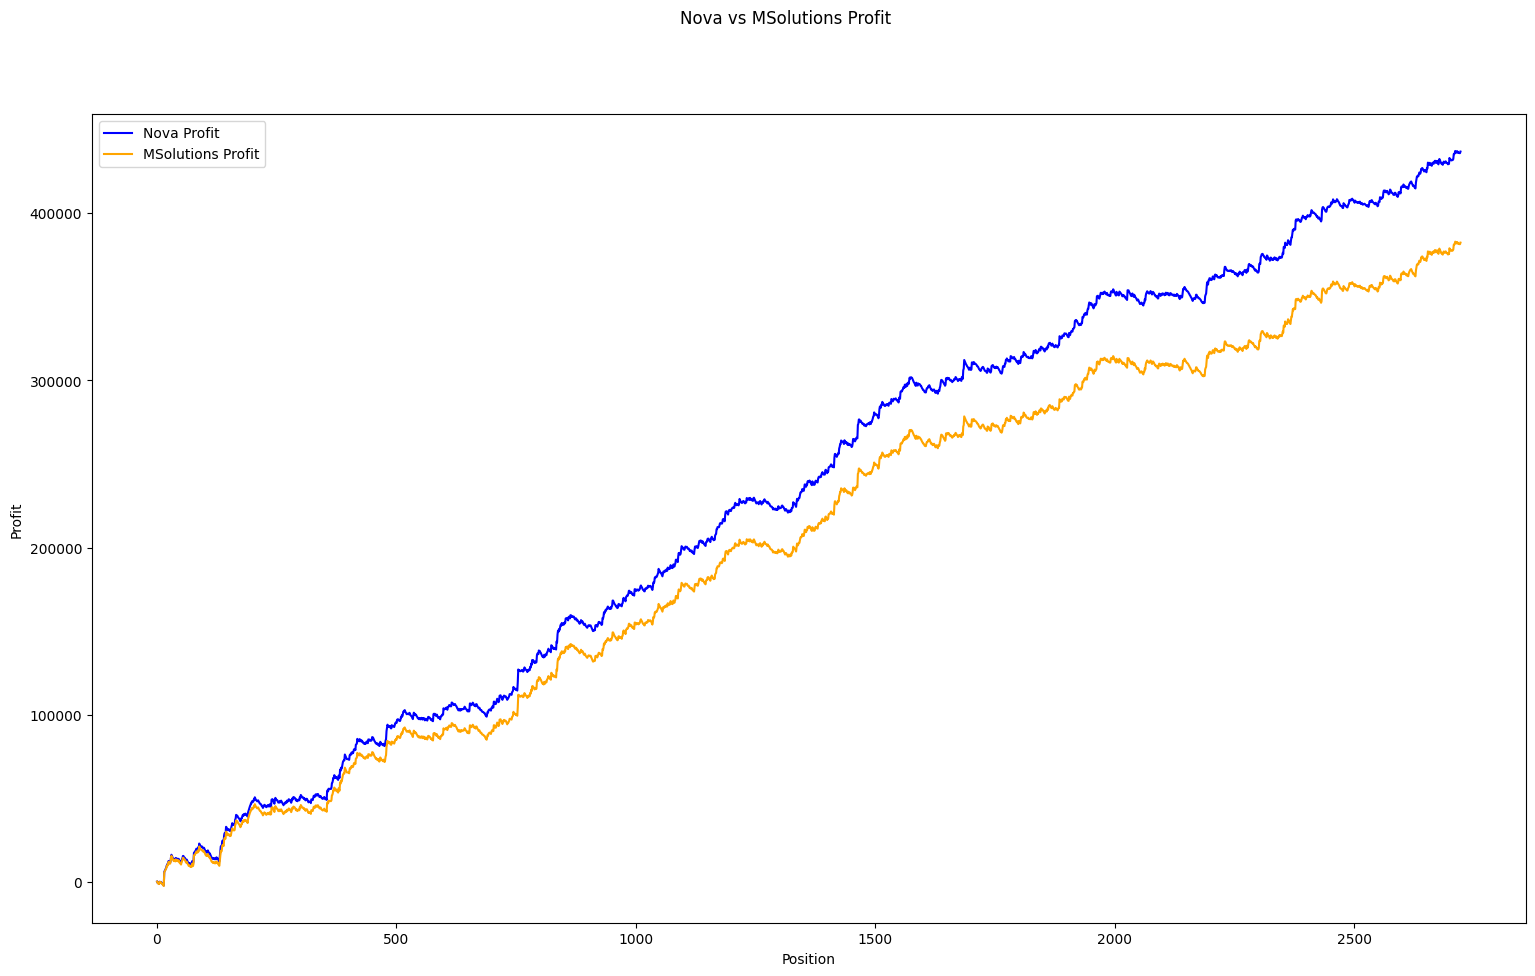

In [77]:
# graph nova_profit_dollars and msolutions_profit_dollars over cum_position_count
fig, ax = plt.subplots()
ax.plot(profit_df['nova_cum_sum'], label='Nova Profit', color='blue')
ax.plot(profit_df['msolutions_cum_sum'], label='MSolutions Profit', color='orange')
ax.set_xlabel('Position')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Profit')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)
# Add legend
ax.legend()
# Show the plot
plt.show()


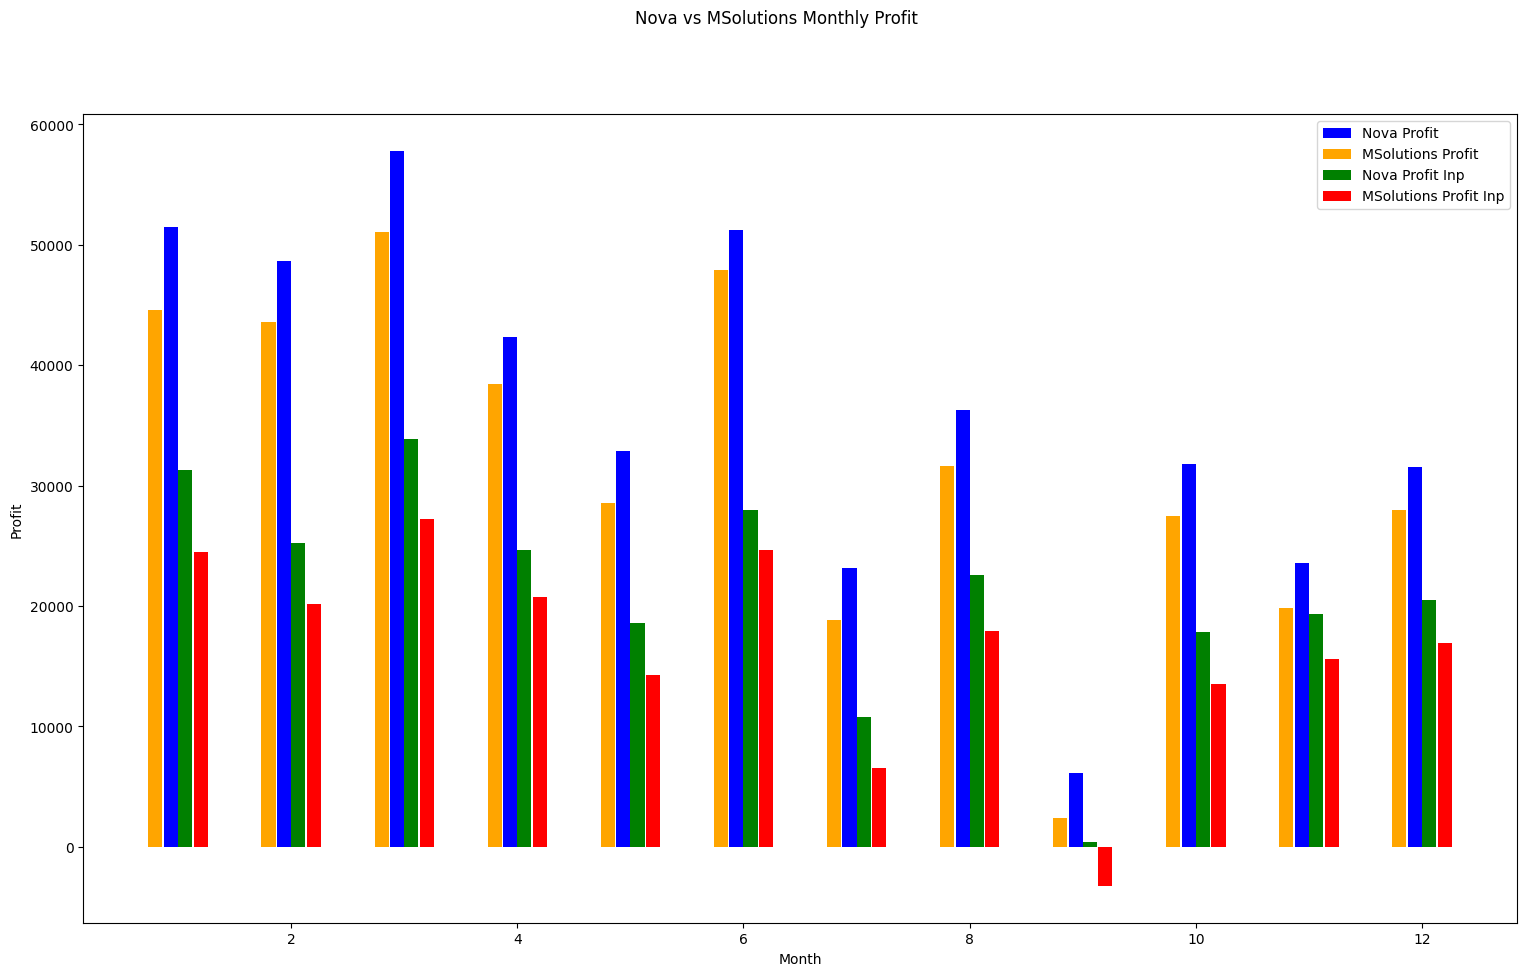

In [78]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_monthly['month'] = profit_df_monthly.index.month
# add a column for the month name
profit_df_monthly['month_name'] = profit_df_monthly.index.strftime('%B')
# profit_df_monthly

# Nova Profit
ax.bar(profit_df_monthly.month - width/8, profit_df_monthly['nova_profit'], label='Nova Profit', color='blue', width=width/4)

# MSolutions Profit
ax.bar(profit_df_monthly.month - width/2.5, profit_df_monthly['msolutions_profit'], label='MSolutions Profit', color='orange', width=width/4)

# Nova Profit Input
ax.bar(profit_df_monthly.month + width/8, profit_df_monthly['nova_profit_inp'], label='Nova Profit Inp', color='green', width=width/4)

# MSolutions Profit Input
ax.bar(profit_df_monthly.month + width/2.5, profit_df_monthly['msolutions_profit_inp'], label='MSolutions Profit Inp', color='red', width=width/4)

# set the x axis to be the month name
# ax.set_xticks(profit_df_monthly.month_name)

ax.set_xlabel('Month')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Monthly Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


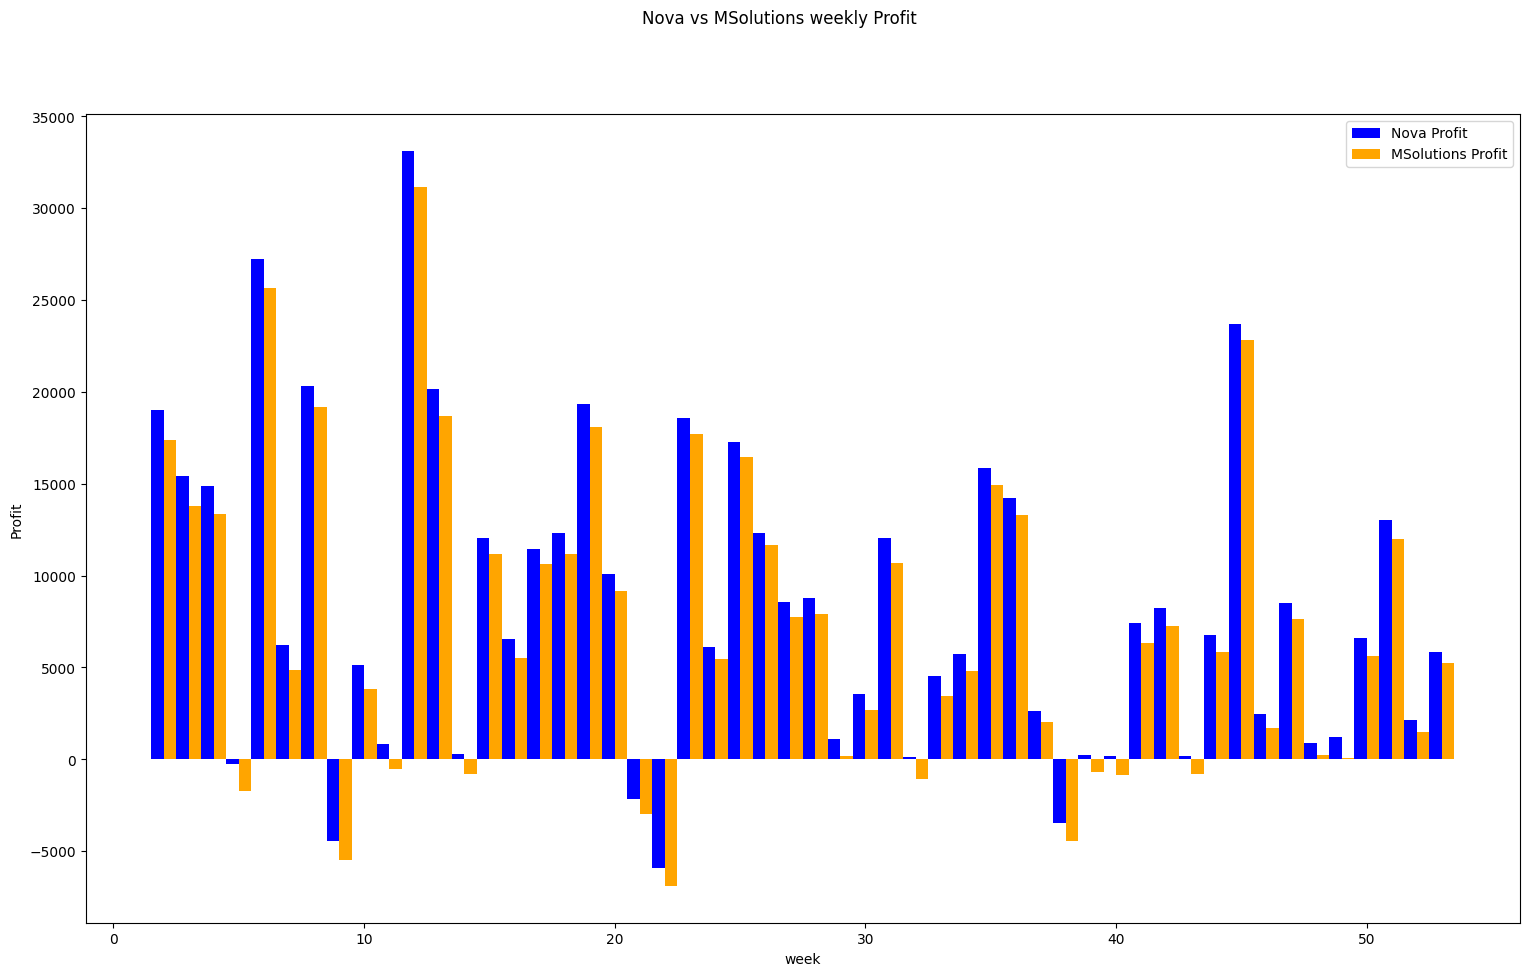

In [79]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_weekly['week'] = profit_df_weekly.index.isocalendar().week
# add a column for the week name
profit_df_weekly['week_name'] = profit_df_weekly.index.strftime('%U')
# convert the week_name to an integer
profit_df_weekly['week_name'] = profit_df_weekly['week_name'].astype(int)
# profit_df_weekly

# Nova Profit
ax.bar(profit_df_weekly.week_name - width/2, profit_df_weekly['nova_profit'], label='Nova Profit', color='blue', width=width)

# MSolutions Profit
ax.bar(profit_df_weekly.week_name + width/2, profit_df_weekly['msolutions_profit'], label='MSolutions Profit', color='orange', width=width)

# Nova Profit Input
# ax.bar(profit_df_weekly.week + width/8, profit_df_weekly['nova_profit_inp'], label='Nova Profit Inp', color='green', width=width/4)

# # MSolutions Profit Input
# ax.bar(profit_df_weekly.week + width/2.5, profit_df_weekly['msolutions_profit_inp'], label='MSolutions Profit Inp', color='red', width=width/4)

# set the x axis to be the week name
# ax.set_xticks(profit_df_weekly.week_name)

ax.set_xlabel('week')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions weekly Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [80]:
# what is the median of nova_profit
nova_median = profit_df_weekly['nova_profit'].median()
print('Nova Median: ', nova_median)
# what is the average
nova_mean = profit_df_weekly['nova_profit'].mean()
print('Nova Mean: ', nova_mean)

Nova Median:  6672.258273508714
Nova Mean:  8399.317931963567


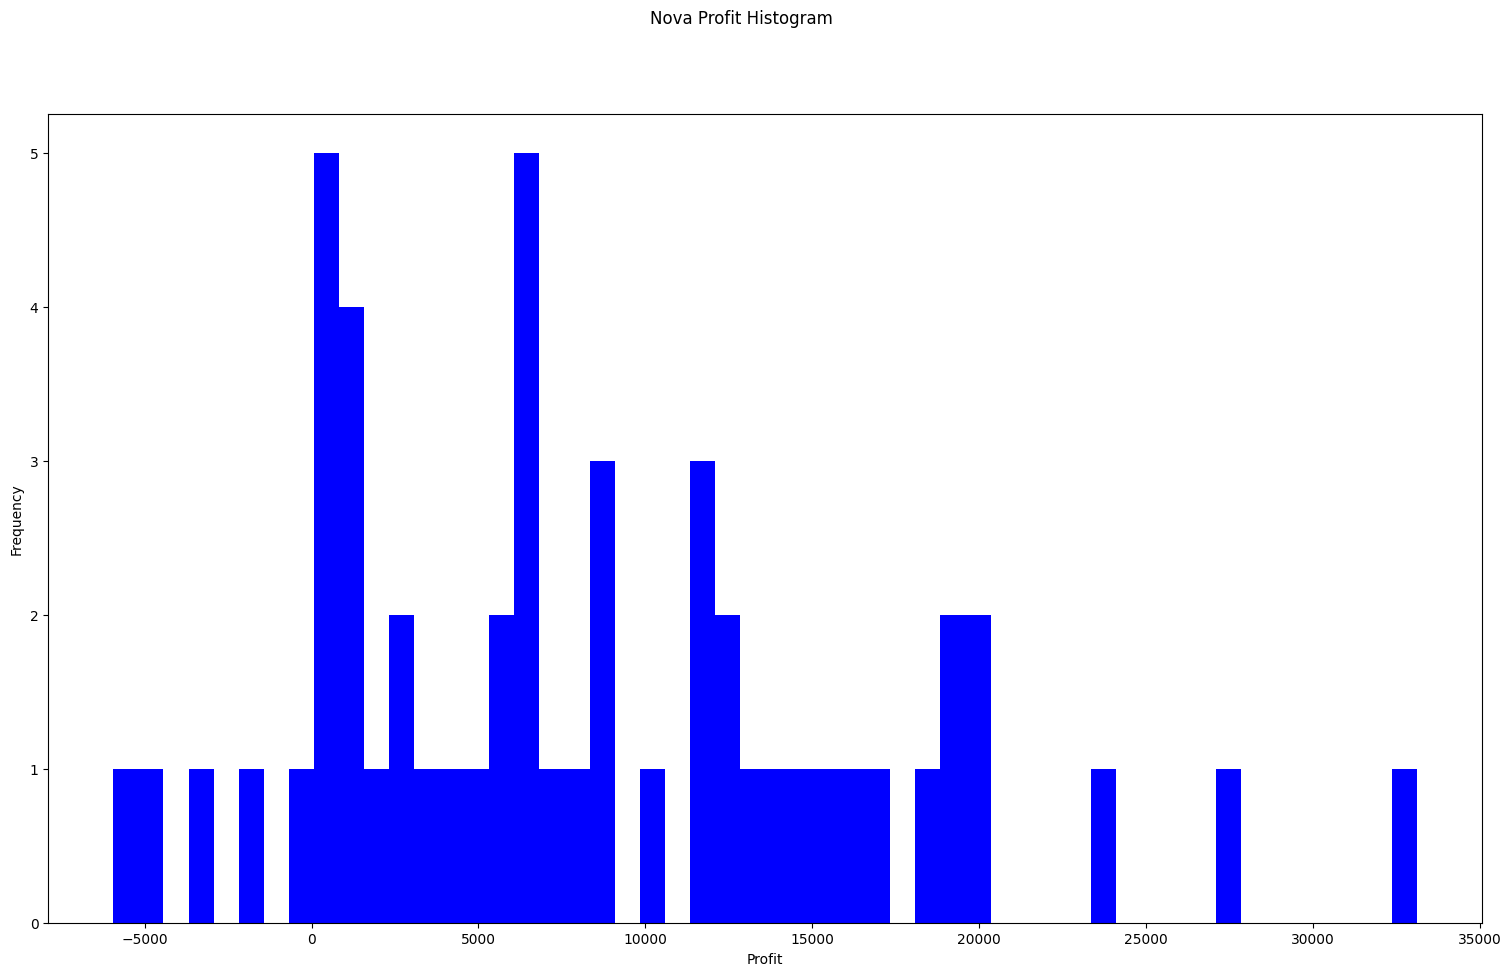

In [81]:
# create a histogram of the nova_profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_weekly['nova_profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Nova Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


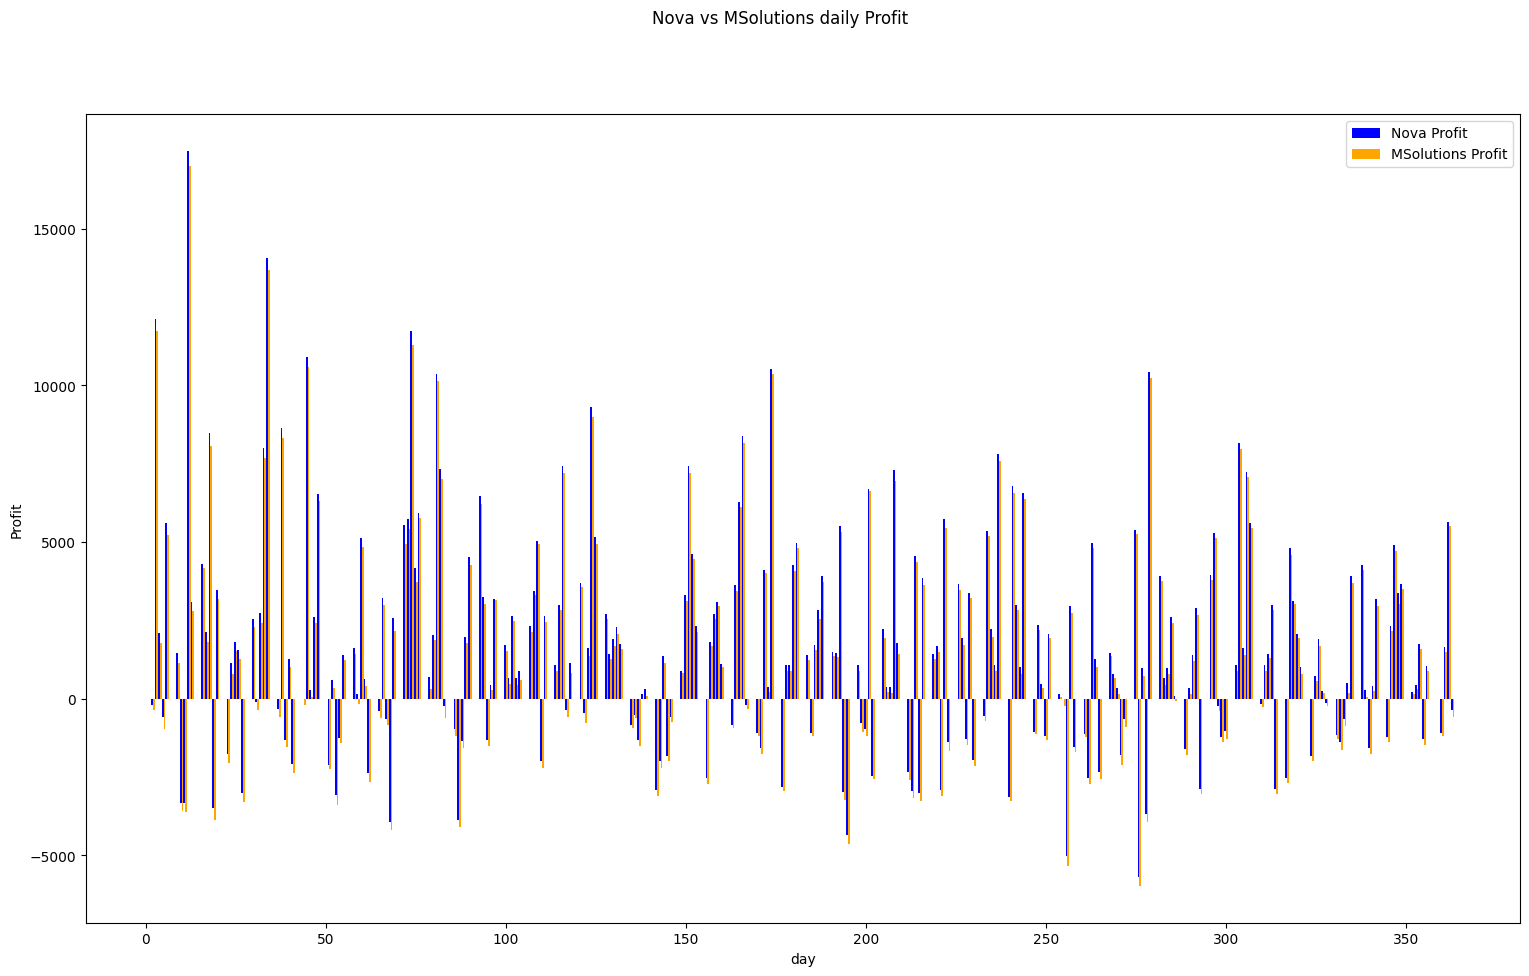

In [82]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_daily['day_number'] = profit_df_daily.index.dayofyear 
# add a column for the 
profit_df_daily['day_name'] = profit_df_daily.index.strftime('%U')
# convert the dai_name to an integer
profit_df_daily['day_name'] = profit_df_daily['day_name'].astype(int)
# profit_df_daily

# Nova Profit
ax.bar(profit_df_daily.day_number - width/2, profit_df_daily['nova_profit'], label='Nova Profit', color='blue', width=width)

# MSolutions Profit
ax.bar(profit_df_daily.day_number + width/2, profit_df_daily['msolutions_profit'], label='MSolutions Profit', color='orange', width=width)

ax.set_xlabel('day')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions daily Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


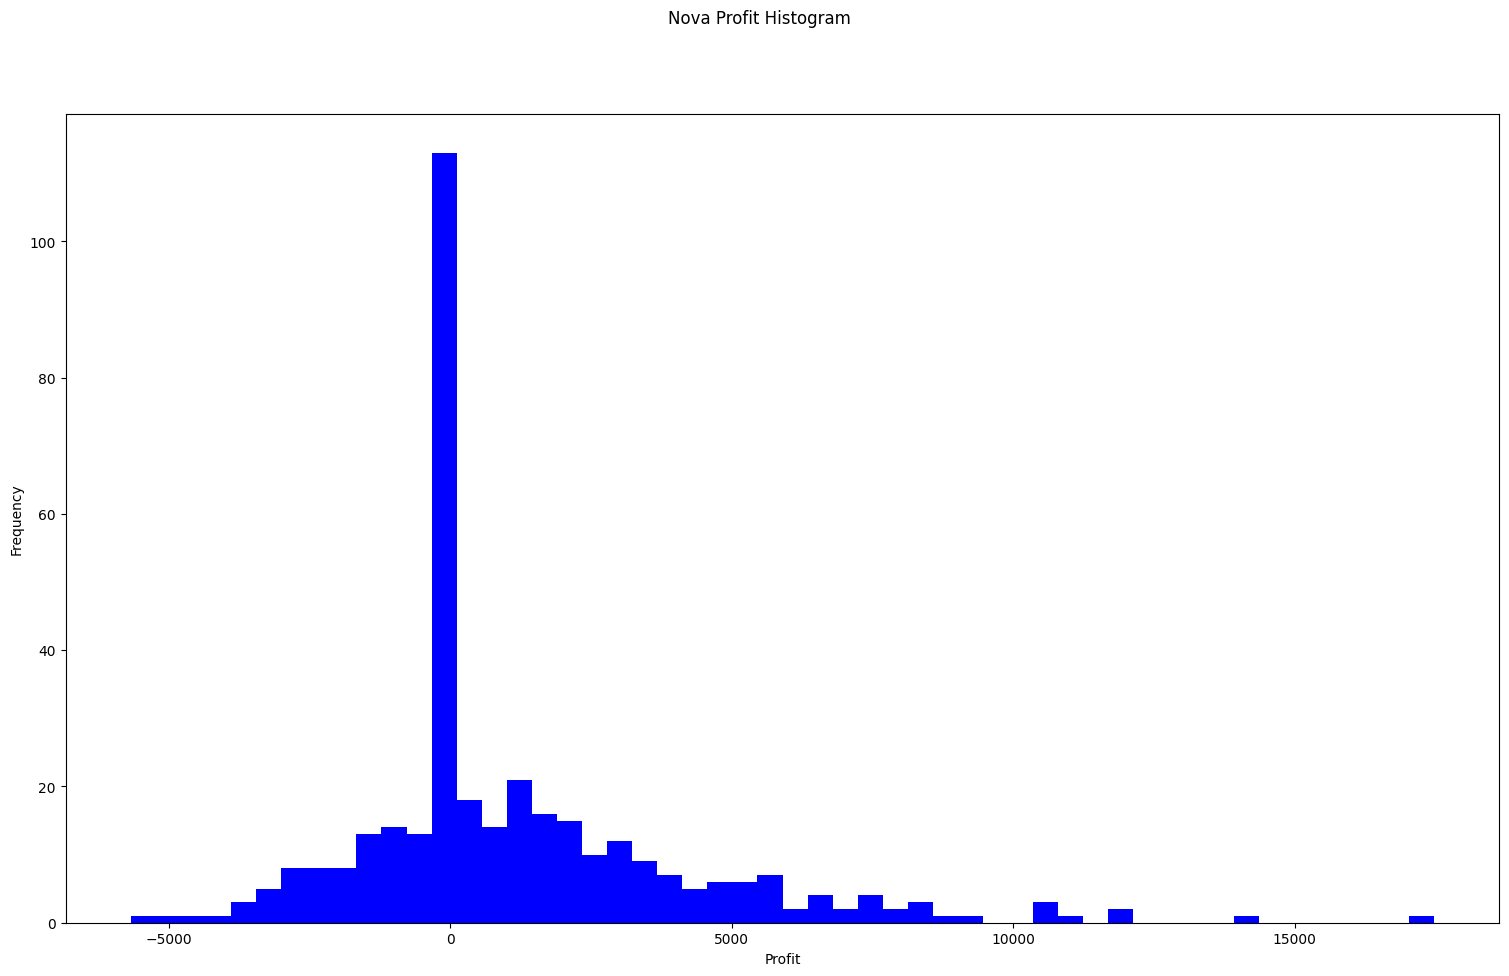

In [83]:
# create a histogram of the nova_profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_daily['nova_profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Nova Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


In [84]:
# show the bins and counts from histogram in a table
nova_profit_hist = np.histogram(profit_df_daily['nova_profit'], bins=52)
# put this into a pandas dataframe
nova_profit_hist_df = pd.DataFrame({'bin': nova_profit_hist[1][:-1], 'count': nova_profit_hist[0]})
nova_profit_hist_df


,bin,count
0,-5676.155527,1
1,-5230.844843,1
2,-4785.534160,1
3,-4340.223477,1
4,-3894.912794,3
5,-3449.602111,5
6,-3004.291427,8
7,-2558.980744,8
8,-2113.670061,8
9,-1668.359378,13


In [85]:
# how many entry times were within 5 minutes of 8:30 am
# separate the hours and minutes from the entry_time column
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df['entry_hour'] = profit_df['entry_time'].dt.hour
profit_df['entry_minute'] = profit_df['entry_time'].dt.minute

# if the entry_hour is 8 and the entry_minute is between 25 and 35 then add a column called 'entry_8_30' and set it to 1
profit_df['entry_8_30'] = np.where((profit_df['entry_hour'] == 8) & (profit_df['entry_minute'] >= 25) & (profit_df['entry_minute'] <= 35), 1, 0)
# find the sum of the entry_8_30 column
entry_8_30_count = profit_df['entry_8_30'].sum()
print('Entry 8:30 Count: ', entry_8_30_count)

Entry 8:30 Count:  16


## Hour distribution

In [86]:
# find the win rate grouped by entry_hour
win_rate_by_hour = profit_df.groupby('entry_hour').agg({'nova_profit': lambda x: (x > 0).sum() / x.count()})
win_rate_by_hour

,nova_profit
entry_hour,
0,0.200000
1,0.377778
2,0.361111
3,0.308824
4,0.386667
5,0.318182
6,0.300000
7,0.230769
8,0.361111


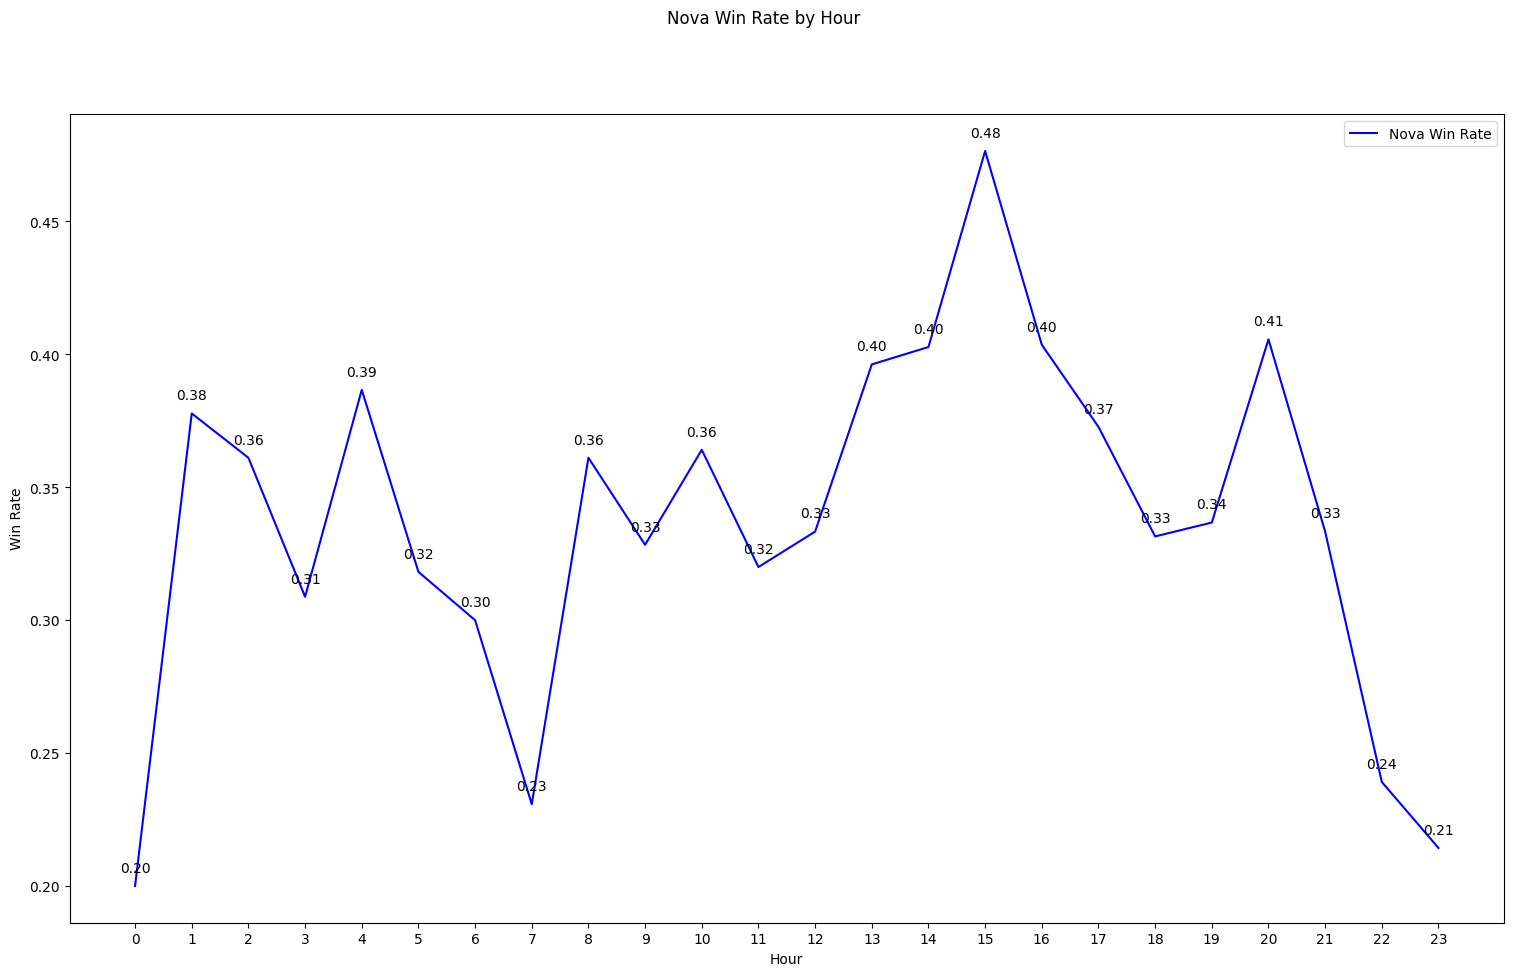

In [87]:
# create a line graph of the win rate by hour
fig, ax = plt.subplots()
ax.plot(win_rate_by_hour.index, win_rate_by_hour['nova_profit'], label='Nova Win Rate', color='blue')
# show the values for x and y next to the points
for i, txt in enumerate(win_rate_by_hour['nova_profit']):
    ax.annotate(f'{txt:.2f}', (win_rate_by_hour.index[i], win_rate_by_hour['nova_profit'][i]), textcoords="offset points", xytext=(0,10), ha='center')
# show all of the ticks on the x axis
ax.set_xticks(win_rate_by_hour.index)
ax.set_xlabel('Hour')
ax.set_ylabel('Win Rate')
fig.suptitle('Nova Win Rate by Hour')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [92]:
# filter out any rows that have entry_hour as 
low_win_perc_hrs = [0, 22, 23]
low_win_perc_removed = profit_df[~profit_df.entry_hour.isin(low_win_perc_hrs)]
# find the sum of nova profit for low_win_perc_removed
print(low_win_perc_removed['nova_profit'].sum(), profit_df['nova_profit'].sum())
# 450,269.5324621328 436,764.53246210545 (0,7,22,23)
# 447,864.53246212745 436,764.53246210545 - nighttime hours (0,22,23)


447864.53246212745 436764.53246210545


In [90]:
# export the profit_df to a csv
# profit_df.to_csv('profit_df.csv')